In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# Adjust these parameters
input_shape = (129, 22499)  # Shape of your spectrogram
latent_dim = 16             # Size of the latent space

# Define the Encoder
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(512, activation="relu")
        self.dense2 = layers.Dense(256, activation="relu")
        self.mu = layers.Dense(latent_dim)  # Mean of the latent space
        self.logvar = layers.Dense(latent_dim)  # Log variance of the latent space

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

# Define the Decoder
class Decoder(Model):
    def __init__(self, latent_dim, original_shape):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(256, activation="relu")
        self.dense2 = layers.Dense(512, activation="relu")
        self.output_layer = layers.Dense(np.prod(original_shape), activation="sigmoid")  # Flattened shape
        self.reshape_layer = layers.Reshape(original_shape)  # Reshape back to the original shape

    def call(self, z):
        x = self.dense1(z)
        x = self.dense2(x)
        x = self.output_layer(x)
        return self.reshape_layer(x)

# Define the VAE
class VAE(Model):
    def __init__(self, latent_dim, original_shape):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, original_shape)

    def reparameterize(self, mu, logvar):
        epsilon = tf.random.normal(shape=tf.shape(mu))
        return mu + tf.exp(0.5 * logvar) * epsilon

    def call(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

"""# Loss function
def vae_loss(x, x_recon, mu, logvar):
    recon_loss = tf.reduce_mean(
        tf.keras.losses.mean_squared_error(x, x_recon)
    )
    kl_divergence = -0.5 * tf.reduce_mean(
        1 + logvar - tf.square(mu) - tf.exp(logvar)
    )
    return recon_loss + kl_divergence"""

# Loss function
def vae_loss(x, x_recon, mu, logvar):
    recon_loss_fn = tf.keras.losses.MeanSquaredError()
    recon_loss = tf.reduce_mean(recon_loss_fn(x, x_recon))
    
    kl_divergence = -0.5 * tf.reduce_mean(
        1 + logvar - tf.square(mu) - tf.exp(logvar)
    )
    return recon_loss + kl_divergence

# Training step
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        x_recon, mu, logvar = model(x)
        loss = vae_loss(x, x_recon, mu, logvar)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Initialize the VAE and optimizer
vae = VAE(latent_dim, input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [4]:
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │ 1,486,154,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │ 1,489,052,259 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,975,206,275 (11.08 GB)

 Trainable params: 2,975,206,275 (11.08 GB)

 Non-trainable params: 0 (0.00 B)

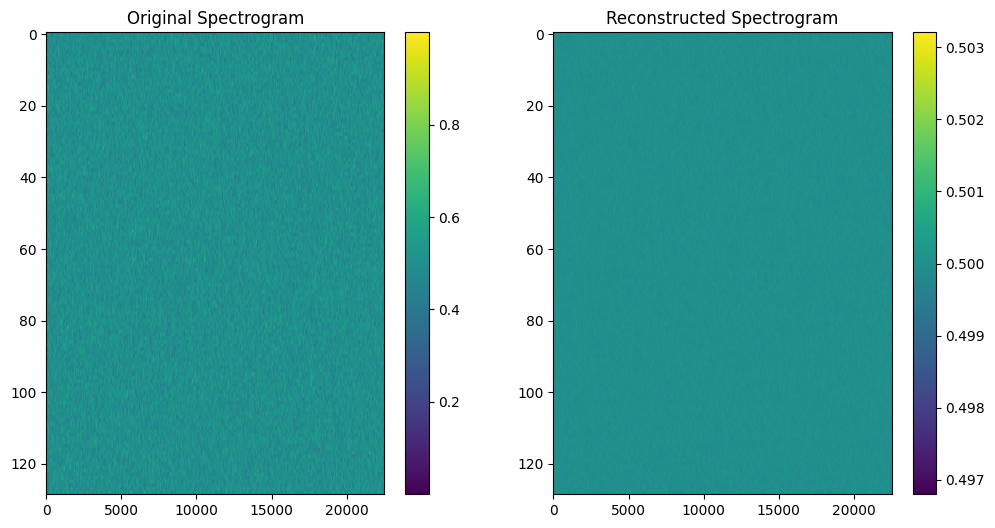

In [3]:

# Data preparation
# Assuming data is already in a NumPy array with shape [num_samples, 129, 22499]
data = np.random.rand(100, *input_shape).astype("float32")  # Example data
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(100).batch(batch_size)

"""# Training loop
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for step, x in enumerate(train_dataset):
        loss = train_step(vae, x, optimizer)
    print(f"Loss: {loss:.4f}")"""

# Test reconstruction
x_sample = data[:1]
x_recon, _, _ = vae(x_sample)

# Plot original and reconstructed spectrograms
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Spectrogram")
plt.imshow(x_sample[0], aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Reconstructed Spectrogram")
plt.imshow(x_recon[0].numpy(), aspect='auto', cmap='viridis')
plt.colorbar()

plt.show()


In [ ]:
#129 22499

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the encoder
def create_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    # Convolutional layers to downsample the input
    x = layers.Conv2D(32, (3, 3), activation="relu", strides=(2, 2), padding="same")(inputs)
    x = layers.Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    shape_before_flattening = tf.keras.backend.int_shape(x)[1:]  # Save this shape for the decoder
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder, shape_before_flattening

# Define the decoder
def create_decoder(latent_dim, shape_before_flattening):
    latent_inputs = layers.Input(shape=(latent_dim,))
    
    # Compute the number of elements for Dense layer
    num_units = shape_before_flattening[0] * shape_before_flattening[1] * shape_before_flattening[2]
    
    x = layers.Dense(num_units, activation="relu")(latent_inputs)
    x = layers.Reshape(shape_before_flattening)(x)  # Reshape to match the last encoder Conv2D layer
    x = layers.Conv2DTranspose(128, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    x = layers.Cropping2D(((3, 4), (2, 3)))(x)  # Crop extra rows/columns to match
    outputs = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, outputs, name="decoder")
    return decoder

# Create the VAE model
input_shape = (129, 22499, 1)  # Add channel dimension for Conv2D compatibility
latent_dim = 16

encoder, shape_before_flattening = create_encoder(input_shape, latent_dim)
decoder = create_decoder(latent_dim, shape_before_flattening)

# VAE Model
inputs = layers.Input(shape=input_shape)
z_mean, z_log_var, z = encoder(inputs)
reconstructed = decoder(z)
vae = Model(inputs, reconstructed, name="vae")

# Define the VAE loss
def vae_loss(x, x_reconstructed, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(x, x_reconstructed)
    )
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return reconstruction_loss + kl_loss

"""class VAELoss(Layer):
    def call(self, x, x_reconstructed, z_mean, z_log_var):
        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_reconstructed)) -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
"""

# Compile the VAE
vae.add_loss(vae_loss(inputs, reconstructed, z_mean, z_log_var))

vae.compile(optimizer=tf.keras.optimizers.Adam())

# Model summary
vae.summary()


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [5]:
inputs, reconstructed

(<KerasTensor shape=(None, 129, 1000, 1), dtype=float32, sparse=False, name=keras_tensor_17>,
 <KerasTensor shape=(None, 129, 995, 1), dtype=float32, sparse=False, name=keras_tensor_21>)

In [ ]:
print(encoder.summary())


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 129,       │          0 │ -                 │
│ (InputLayer)        │ 22499, 1)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 65, 11250, │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 5625,  │     18,496 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 17, 2813,  │     73,856 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 6121088)   │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │ 1,566,998… │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      4,112 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      4,112 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,567,099,680 (5.84 GB)

 Trainable params: 1,567,099,680 (5.84 GB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
print(decoder.summary())


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6121088)        │   104,058,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 17, 2813, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 34, 5626, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 68, 11252, 64)  │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 136, 22504, 32) │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 136, 22504, 1)  │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,298,625 (397.87 MB)

 Trainable params: 104,298,625 (397.87 MB)

 Non-trainable params: 0 (0.00 B)

None


## Go from here:

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Layer

In [3]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [7]:

# Define the encoder
def create_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    # Convolutional layers to downsample the input
    x = layers.Conv2D(32, (3, 3), activation="relu", strides=(2, 2), padding="same")(inputs)
    x = layers.Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    shape_before_flattening = tf.keras.backend.int_shape(x)[1:]  # Save this shape for the decoder
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder, shape_before_flattening

# Define the decoder
def create_decoder(latent_dim, shape_before_flattening):
    latent_inputs = layers.Input(shape=(latent_dim,))
    
    # Compute the number of elements for Dense layer
    num_units = shape_before_flattening[0] * shape_before_flattening[1] * shape_before_flattening[2]
    
    x = layers.Dense(num_units, activation="relu")(latent_inputs)
    x = layers.Reshape(shape_before_flattening)(x)  # Reshape to match the last encoder Conv2D layer
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation="relu", strides=(2, 2), padding="same")(x)
    x = layers.Cropping2D(((3, 4), (0, 0)))(x)  # Crop extra rows/columns to match
    outputs = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, outputs, name="decoder")
    return decoder

# Create the VAE model
input_shape = (129, 1000, 1)  # Add channel dimension for Conv2D compatibility
latent_dim = 16

encoder, shape_before_flattening = create_encoder(input_shape, latent_dim)
decoder = create_decoder(latent_dim, shape_before_flattening)

# VAE Model
inputs = layers.Input(shape=input_shape)
z_mean, z_log_var, z = encoder(inputs)
reconstructed = decoder(z)
vae = Model(inputs, reconstructed, name="vae")

# Define the VAE Loss Layer
class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_reconstructed, z_mean, z_log_var = inputs

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x, x_reconstructed)
        )
        
        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        
        # Add total loss
        self.add_loss(reconstruction_loss + kl_loss)
        return x_reconstructed

# Example usage in VAE
vae_inputs = layers.Input(shape=input_shape)
z_mean, z_log_var, z = encoder(vae_inputs)
vae_outputs = decoder(z)

# Add the loss layer
vae_loss_layer = VAELossLayer()([vae_inputs, vae_outputs, z_mean, z_log_var])
vae = tf.keras.Model(vae_inputs, vae_loss_layer)

#vae.compile(optimizer=tf.keras.optimizers.Adam())

# Model summary
#vae.summary()


In [8]:
inputs, reconstructed

(<KerasTensor shape=(None, 129, 1000, 1), dtype=float32, sparse=False, name=keras_tensor_44>,
 <KerasTensor shape=(None, 129, 1000, 1), dtype=float32, sparse=False, name=keras_tensor_48>)

In [9]:
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Model summary
vae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 129, 1000, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 16),      │  8,761,888 │ input_layer_7[0]… │
│ (Functional)        │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 129, 1000, │  2,404,609 │ encoder[1][2]     │
│ (Functional)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_1    │ (None, 129, 1000, │          0 │ input_layer_7[0]… │
│ (VAELossLayer)      │ 1)                │            │ decoder[1][0],    │
│                     │                   │            │ encoder[1][0],    │
│                     │                   │            │ encoder[1][1]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,166,497 (42.60 MB)

 Trainable params: 11,166,497 (42.60 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
print(encoder.summary())


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 129, 1000, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 65, 500,   │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 250,   │     18,496 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 17, 125,   │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 136000)    │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │  8,704,064 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      1,040 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      1,040 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,761,888 (33.42 MB)

 Trainable params: 8,761,888 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
print(decoder.summary())


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 136000)         │     2,312,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 17, 125, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 34, 250, 64)    │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 68, 500, 64)    │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 136, 1000, 32)  │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_1 (Cropping2D)       │ (None, 129, 1000, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 129, 1000, 1)   │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,404,609 (9.17 MB)

 Trainable params: 2,404,609 (9.17 MB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:

# Data preparation
# Assuming data is already in a NumPy array with shape [num_samples, 129, 22499]
data = np.random.rand(100, *input_shape).astype("float32")  # Example data
batch_size = 8
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(100).batch(batch_size)

# Training step
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        #x_recon, mu, logvar = model(x)
        x_recon, mu, logvar, z = model(x)
        loss = vae_loss(x, x_recon, mu, logvar)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for step, x in enumerate(train_dataset):
        loss = train_step(vae, x, optimizer)
    print(f"Loss: {loss:.4f}")

# Test reconstruction
x_sample = data[:1]
#x_recon, _, _ = vae(x_sample)
x_recon = vae(x_sample)

# Plot original and reconstructed spectrograms
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Spectrogram")
plt.imshow(x_sample[0], aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Reconstructed Spectrogram")
plt.imshow(x_recon[0].numpy(), aspect='auto', cmap='viridis')
plt.colorbar()

plt.show()

Epoch 1/1


ValueError: too many values to unpack (expected 4)

In [14]:
data.shape

(100, 129, 1000, 1)